# Introduction

# 0.0. Imports

In [1]:
# Import the relevant libraries

# Data manipulation
import pandas as pd
import numpy as np

# Statistics
from scipy import stats

# Graphs
import matplotlib.pyplot as plt
import seaborn as sns

# Load images
from IPython.display import Image

# Warning
import warnings
warnings.filterwarnings( 'ignore' )

# Feature selection
from boruta import BorutaPy

# Stats
from scipy import stats

# Scalers
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder, LabelEncoder

# Save files
import pickle

# Model selection
from sklearn.model_selection import train_test_split

# Machine Learning models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Model's cross-validation
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict, RandomizedSearchCV,\
GridSearchCV

# Model's metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,\
confusion_matrix, matthews_corrcoef, make_scorer, roc_curve

# 0.1 Helper Functions

In [2]:
# Percentual plot
def percentual_count(var: str, dataset: pd.DataFrame):
    ax = sns.countplot(y=var, data=dataset)
    total = len(dataset[var])
    for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_width()/total)
            x = p.get_x() + p.get_width() + 0.02
            y = p.get_y() + p.get_height()/2
            ax.annotate(percentage, (x, y))
    return plt.show()

In [3]:
def cramers_corrected_stat(x, y):
    """ calculate Cramers V statistic for categorial-categorial association.
    """
    # Calculate confusion matrix
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape

    # Calculate chi2
    chi2 = stats.chi2_contingency(cm)[0]
    # Calculate chi2 correction
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    # K correction
    kcorr = k - (k-1)**2/(n-1)
    # R correction
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

In [4]:
# Model's performance
def ml_scores(model_name, y_train, y_pred):
    
    accuracy = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    recall = recall_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)
    roc = roc_auc_score(y_train, y_pred)
    
    return pd.DataFrame({'Accuracy': np.round(accuracy, 6), 
                         'Precision': np.round(precision, 6), 
                         'Recall': np.round(recall, 6),
                         'F1': np.round(f1, 6),
                         'ROC': np.round(kappa, 6)}, 
                        index=[model_name])

In [5]:
# Model's performance function
def cross_val_performance(model_name, y_train, y_pred):
    # define scoring metrics
    scoring = {'Accuracy': 'accuracy',
               'Precision': make_scorer(precision_score),
               'Recall': make_scorer(recall_score),
               'F1': make_scorer(f1_score),
               'ROC': make_scorer(roc_auc_score)}

    # calculate scores with cross_validate
    scores = cross_validate(model, y_train, y_pred, cv=10, scoring=scoring)

    # performance data frame
    performance = pd.DataFrame.from_dict(scores).drop(['fit_time', 'score_time'], axis=1)
    performance = pd.DataFrame(np.round(performance.mean(), 4).astype(str) + '+/-' + np.round(performance.std()*2,4).astype(str))
    return performance

In [6]:
# Confusion Matrix function
def conf_matrix(y_train, y_pred):
    cm = confusion_matrix(y_train, y_pred)
    cm_data = pd.DataFrame(cm, columns = ['Positive', 'Negative'], index=['Positive', 'Negative'])
    sns.heatmap(cm_data, annot=True, cmap='Blues', fmt='d', cbar=False, annot_kws={'size': 24})

    return plt.show()

# 1.0. Data

## 1.1. Load the Data

In [7]:
# Load train data
df_train = pd.read_csv('dataset/train.csv')

# Load test data
df_test = pd.read_csv('dataset/test.csv')

# Load sample submission data
df_ss = pd.read_csv('dataset/sample_submission.csv')

In [8]:
# Creating full dataset

# Merge test with sample submission
df_test_1 = pd.merge(df_test, df_ss, how='right')

# Concating both data
df = pd.concat([df_train, df_test_1])

df.head()

id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0   1    Male   44                1         28.0                   0   
1   2    Male   76                1          3.0                   0   
2   3    Male   47                1         28.0                   0   
3   4    Male   21                1         11.0                   1   
4   5  Female   29                1         41.0                   1   

  Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  \
0   > 2 Years            Yes         40454.0                  26.0      217   
1    1-2 Year             No         33536.0                  26.0      183   
2   > 2 Years            Yes         38294.0                  26.0       27   
3    < 1 Year             No         28619.0                 152.0      203   
4    < 1 Year             No         27496.0                 152.0       39   

   Response  
0         1  
1         0  
2         1  
3         0  
4         0

## 1.2. Data Dimension

In [9]:
print(f'The shape of Dataset is: {df.shape}')

The shape of Dataset is: (508146, 12)


## 1.4. Data Types and Structure

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 508146 entries, 0 to 127036
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    508146 non-null  int64  
 1   Gender                508146 non-null  object 
 2   Age                   508146 non-null  int64  
 3   Driving_License       508146 non-null  int64  
 4   Region_Code           508146 non-null  float64
 5   Previously_Insured    508146 non-null  int64  
 6   Vehicle_Age           508146 non-null  object 
 7   Vehicle_Damage        508146 non-null  object 
 8   Annual_Premium        508146 non-null  float64
 9   Policy_Sales_Channel  508146 non-null  float64
 10  Vintage               508146 non-null  int64  
 11  Response              508146 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 50.4+ MB


* No Null values
* Dataset with 3 types: float64(3), int64(6), object(3)

## 1.5. Columns Description

| Variable             | Definition                                                   | DTYPE   |
| :------------------- | :----------------------------------------------------------- | ------- |
| id                   | Unique ID for the customer                                   | int64   |
| Gender               | Gender of the customer                                       | Object  |
| Age                  | Age of the customer                                          | int64   |
| Driving_License      | 0 : Customer does not have DL, 1 : Customer already has DL   | int64   |
| Region_Code          | Unique code for the region of the customer                   | float64 |
| Previously_Insured   | 1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance | int64   |
| Vehicle_Age          | Age of the Vehicle                                           | object  |
| Vehicle_Damage       | 1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past. | object  |
| Annual_Premium       | The amount customer needs to pay as premium in the year      | float64 |
| Policy*Sales*Channel | Anonymised Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc. | float64 |
| Vintage              | Number of Days, Customer has been associated with the company | int64   |
| Response             | 1 : Customer is interested, 0 : Customer is not interested   | int64   |

## 1.6. Descriptive Statistics

### 1.6.1. Numerical Attributes

In [11]:
num_attr = df.select_dtypes(include=['int64', 'float64'])

In [12]:
describe = num_attr.describe().T

describe['range'] = (num_attr.max() - num_attr.min()).tolist()
describe['unique val.'] = num_attr.nunique()
describe['variation coefficient'] = np.round((num_attr.std() / num_attr.mean()), 4).tolist()
describe['skew'] = np.round(num_attr.skew(), 4).tolist()
describe['kurtosis'] = np.round(num_attr.kurtosis(), 4).tolist()

describe

count           mean            std     min  \
id                    508146.0  254073.500000  146689.259281     1.0   
Age                   508146.0      38.808413      15.500179    20.0   
Driving_License       508146.0       0.997936       0.045388     0.0   
Region_Code           508146.0      26.406572      13.224921     0.0   
Previously_Insured    508146.0       0.458667       0.498289     0.0   
Annual_Premium        508146.0   30554.453041   17146.574625  2630.0   
Policy_Sales_Channel  508146.0     111.975838      54.246027     1.0   
Vintage               508146.0     154.340123      83.668793    10.0   
Response              508146.0       0.091922       0.288917     0.0   

                            25%       50%        75%       max     range  \
id                    127037.25  254073.5  381109.75  508146.0  508145.0   
Age                       25.00      36.0      49.00      85.0      65.0   
Driving_License            1.00       1.0       1.00       1.0       1.0   
Region_Code               15.00      28.0      35.00      52.0      52.0   
Previously_Insured         0.00       0.0       1.00       1.0       1.0   
Annual_Premium         24381.00   31661.0   39403.75  540165.0  537535.0   
Policy_Sales_Channel      26.00     133.0     152.00     163.0     162.0   
Vintage                   82.00     154.0     227.00     299.0     289.0   
Response                   0.00       0.0       0.00       1.0       1.0   

                      unique val.  variation coefficient     skew  kurtosis  
id                         508146                 0.5773  -0.0000   -1.2000  
Age                            66                 0.3994   0.6728   -0.5647  
Driving_License                 2                 0.0455 -21.9412  479.4167  
Region_Code                    53                 0.5008  -0.1170   -0.8650  
Previously_Insured              2                 1.0864   0.1659   -1.9725  
Annual_Premium              52062                 0.5612   1.6002   30.0479  
Policy_Sales_Channel          157                 0.4844  -0.8969   -0.9774  
Vintage                       290                 0.5421   0.0026   -1.2003  
Response                        2                 3.1430   2.8249    5.9800

### 1.6.2. Categorical Attributes

In [13]:
cat_attr = df.select_dtypes(include='object')
cat_attr.describe().T

count unique       top    freq
Gender          508146      2      Male  274325
Vehicle_Age     508146      3  1-2 Year  267015
Vehicle_Damage  508146      2       Yes  256248

# 2.0. Hypothesis Creation

## 2.1. Mind Map Hypothesis

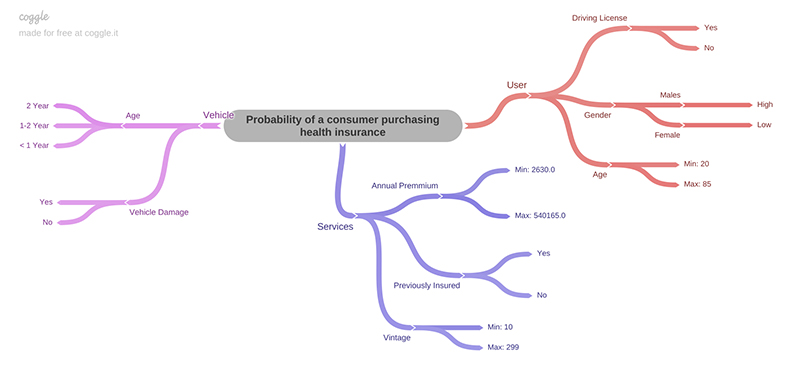

In [14]:
Image('img\Probability_of_a_consumer_purchasing_health_insurance.jpg')

## 2.2. Hypothesis Creation

### 2.2.1. User
1. Males represent 70% of customers with Health Insurance
2. Most health insurance customers are in their 40s
3. All customers with Health Insurance has driving license

### 2.2.2. Vehicle
1. Vehicles under age 1 represents mojority of customers with Health Insurance
2. All Vehicle with damage status represents the majority of customers with Health Insurance

### 2.2.3 Services
1. People with 100 days or more of association with the company are customers
2. Most People with Previous Insured acquire Health Insurance
3. Low fee(annual premium) brings more customers

# 3.0. Feature Engineering

In [15]:
df2 = df.copy()

In [16]:
# Column week creation
df2['week_vintage'] = df2['Vintage'].apply(lambda x: np.ceil(x/7).astype('int'))

# Column month creation
df2['month_vintage'] = df2['Vintage'].apply(lambda x: np.ceil(x/30).astype('int'))

# 4.0 Exploratory Data Analysis

In [17]:
df3 = df2.copy()

## 4.1. Univariate Analysis

### 4.1.1. Target Variable

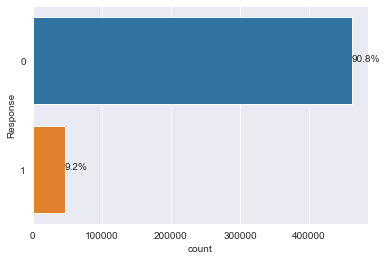

In [18]:
sns.set_style('darkgrid')
percentual_count('Response', df3)

The customer with interest in health insurance is approximately 9%.

### 4.1.2. Numerical Variables Distribution

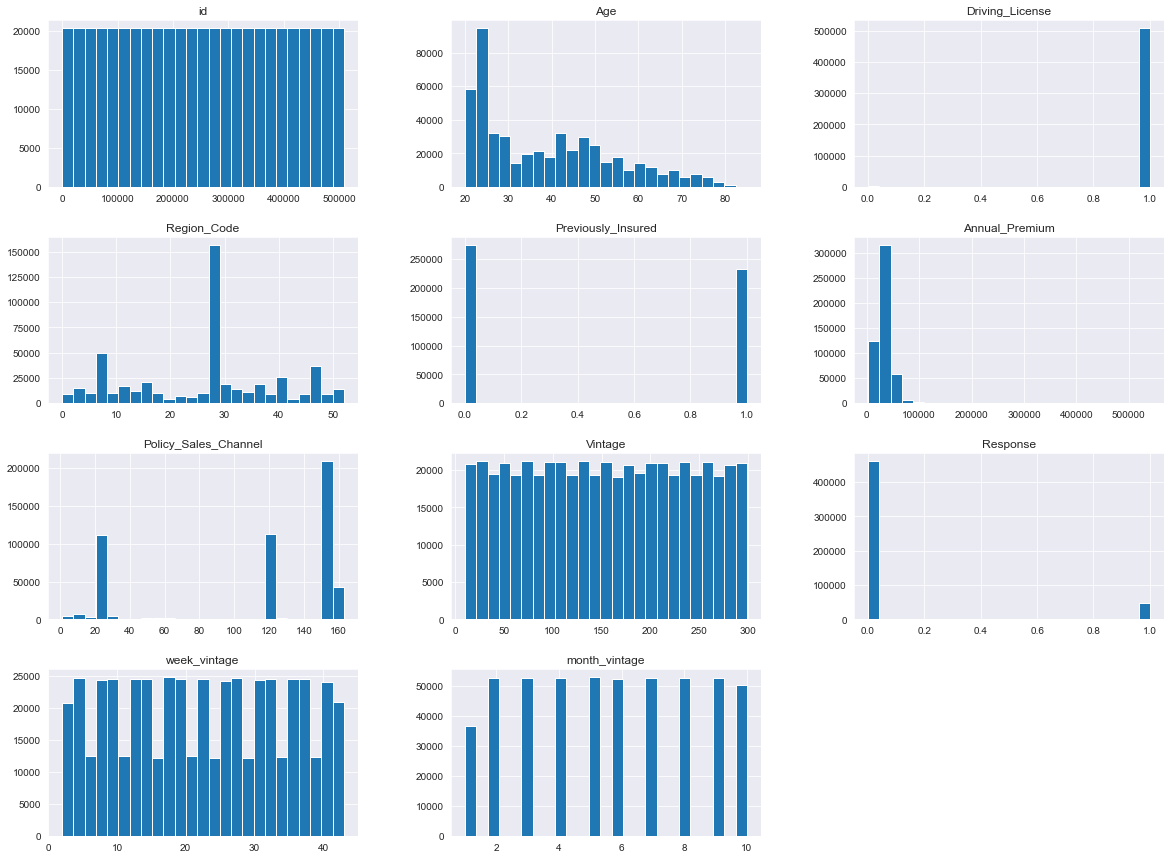

In [19]:
# Plot numerical
df3.select_dtypes(exclude='object').hist(figsize=(20,15), bins=25)
plt.show()

### 4.1.3. Categorical Variable

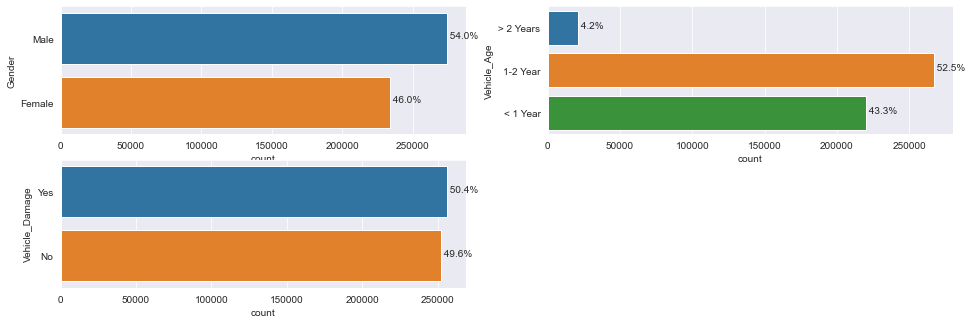

In [20]:
plt.figure(figsize=(16,8))
cat_attributes = df3.select_dtypes(include='object')
columns = cat_attributes.columns.tolist()
j = 1

for column in columns:
    plt.subplot(3, 2, j)
    ax = sns.countplot(y=column, data=cat_attributes)
    
    total = cat_attributes[column].size
    for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
    
    j += 1

## 4.2. Bivariate Analysis

### H1. Males represent 70% of customers with Health Insurance.
**FALSE** : Males represent 61.1%.

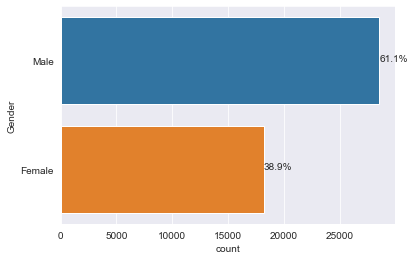

In [21]:
# Dataset with Response = 1
aux1 = df3[df3.Response == 1]

# countplot
percentual_count('Gender', aux1)

### H2. Most health insurance customers are in their 40s
**TRUE**: Customers in their 40s are the majority  

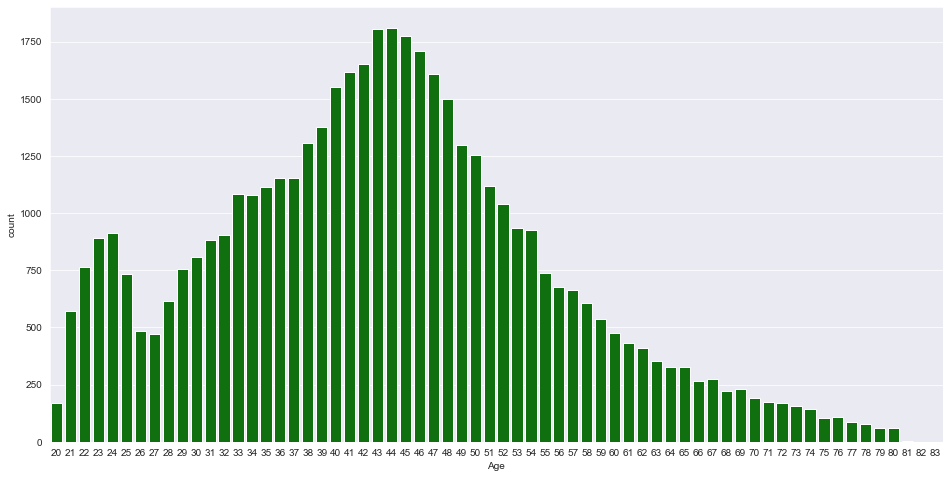

In [22]:
plt.figure(figsize=(16,8))
sns.countplot(x='Age', data=aux1, color='green')
plt.show()

### H3. All customers with Health Insurance has driving license.
**True**: 99.9% of the customers with Health Insurance has driving license

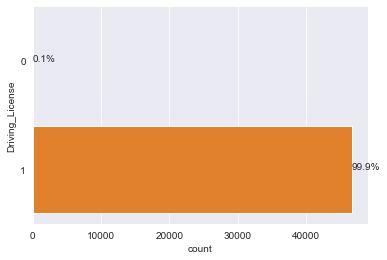

In [23]:
percentual_count('Driving_License', aux1)

### H4.Vehicles under age 1 represents mojority of customers with Health Insurance.
**FALSE**: Vehicles between 1 and 2 are mojority.

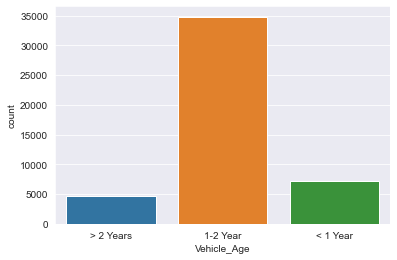

In [24]:
sns.countplot(x='Vehicle_Age', data= aux1)
plt.show()

### H5. All Vehicle with damage status represents the majority of customers with Health Insurance.
**TRUE**: Vehicle with damage status represents 97.9% of customers.

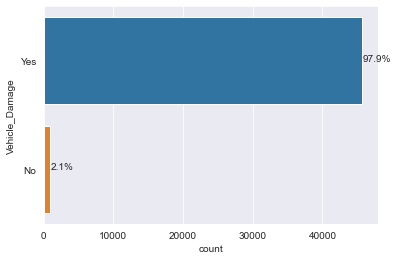

In [25]:
percentual_count('Vehicle_Damage', aux1)

### H6. People with 100 days or more of association with the company are customers.
**TRUE**: It is a uniform distribution.

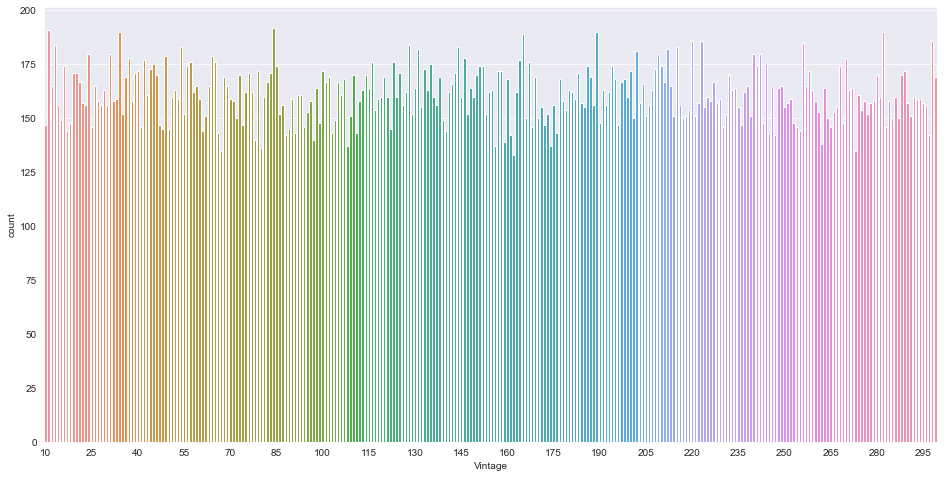

In [26]:
plt.figure(figsize=(16,8))
sns.countplot(x=aux1.Vintage)
plt.xticks(np.arange(0,300, step=15))
plt.show()

### H7. Most People with Previous Insured acquire Health Insurance.
**TRUE**: 99.7% are Previous Insured.

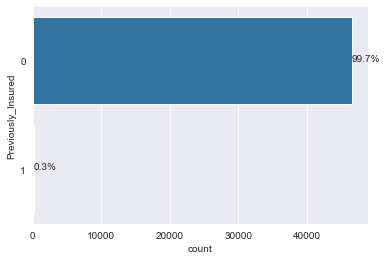

In [27]:
percentual_count('Previously_Insured', aux1)

### H8. Low fee(annual premium) brings more customers.
**TRUE**: Customers who pay less annual premium are the majority.

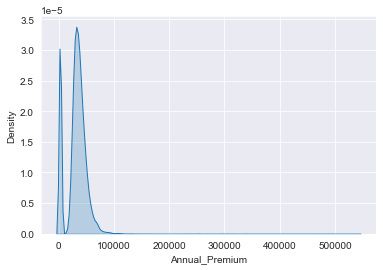

In [28]:
sns.kdeplot(x='Annual_Premium', data=aux1, shade=True)
plt.show()

##

## 4.3. Multivariate Analysis

### 4.3.1. Numerical Atributes

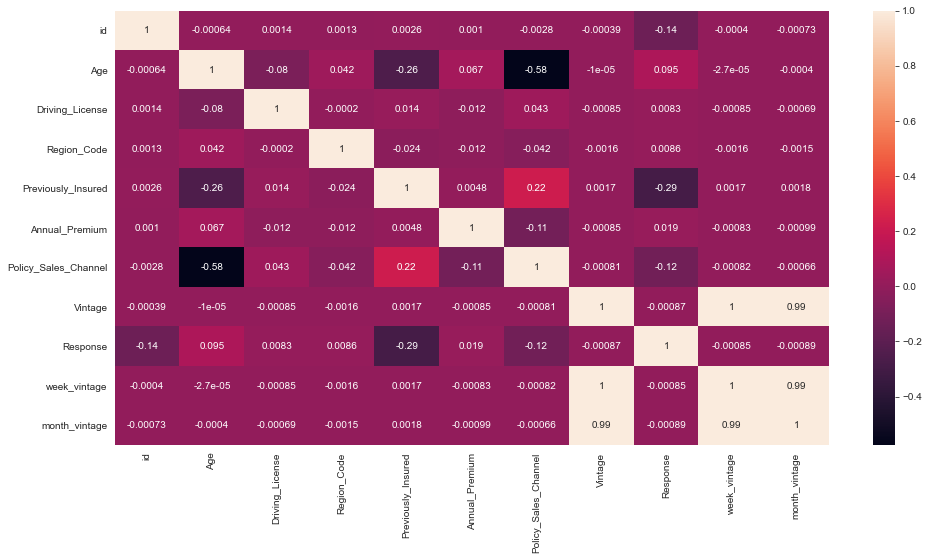

In [29]:
# Correlation by pearson method
correlation = df3.select_dtypes(exclude='object').corr(method='pearson')

# set up figure
plt.figure(figsize=(16,8))
sns.heatmap(correlation, annot=True)
plt.show()

### 4.3.2. Categorical Variables

In [30]:
dict_for_corr = {}
columns = cat_attributes.columns.tolist()

for column in columns:
    dict_for_corr[column] = {}

    for column2 in columns:
        dict_for_corr[column][column2] = cramers_corrected_stat(cat_attributes[column], cat_attributes[column2])

corr_cat = pd.DataFrame(dict_for_corr)

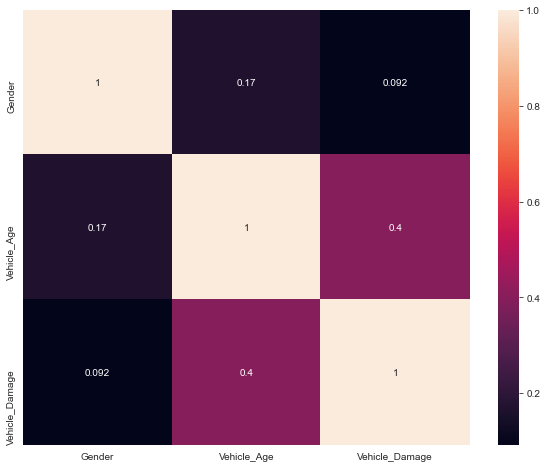

In [31]:
plt.figure(figsize=(10,8))
sns.heatmap(corr_cat, annot=True)
plt.show()

# 5.0. Data Preparation

In [32]:
df4 = df3.copy()

## 5.1. Spliting into Train, Valid and Test

In [33]:
# Remove target variable from train set
X = df4.drop('Response', axis=1)
y = df4.Response

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## 5.2. Tranformation

In [34]:
# x_train.Vehicle_Age = x_train.Vehicle_Age.map(lambda x: x.replace('>< Year', ''))
# Label Encoder
le_cols = ['Gender', 'Vehicle_Damage']
le = LabelEncoder()
for column in le_cols:
    x_train[column] = le.fit_transform(x_train[column])
    x_test[column] = le.transform(x_test[column])

In [35]:
# One Hot Encoder with pandas dummies
ohe = OneHotEncoder()

# Reshape the 1D array in 2D
X_train = ohe.fit_transform(x_train.Vehicle_Age.values.reshape(-1,1)).toarray()
X_test = ohe.transform(x_test.Vehicle_Age.values.reshape(-1,1)).toarray()

# Cols names
cols_names = ['vehicle_mid_age', 'vehicle_new_age', 'vehicle_old_age']
# Add back into the original dataframe
df_ohe_train = pd.DataFrame(X_train, columns=cols_names, dtype='int64')
df_ohe_test = pd.DataFrame(X_test, columns = cols_names, dtype='int64')
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)

x_train = pd.concat([x_train, df_ohe_train], axis=1).drop('Vehicle_Age', axis=1)
x_test = pd.concat([x_test, df_ohe_test], axis=1).drop('Vehicle_Age', axis=1)

## 5.3. Rescaling

### 5.3.1. Checking Outlier

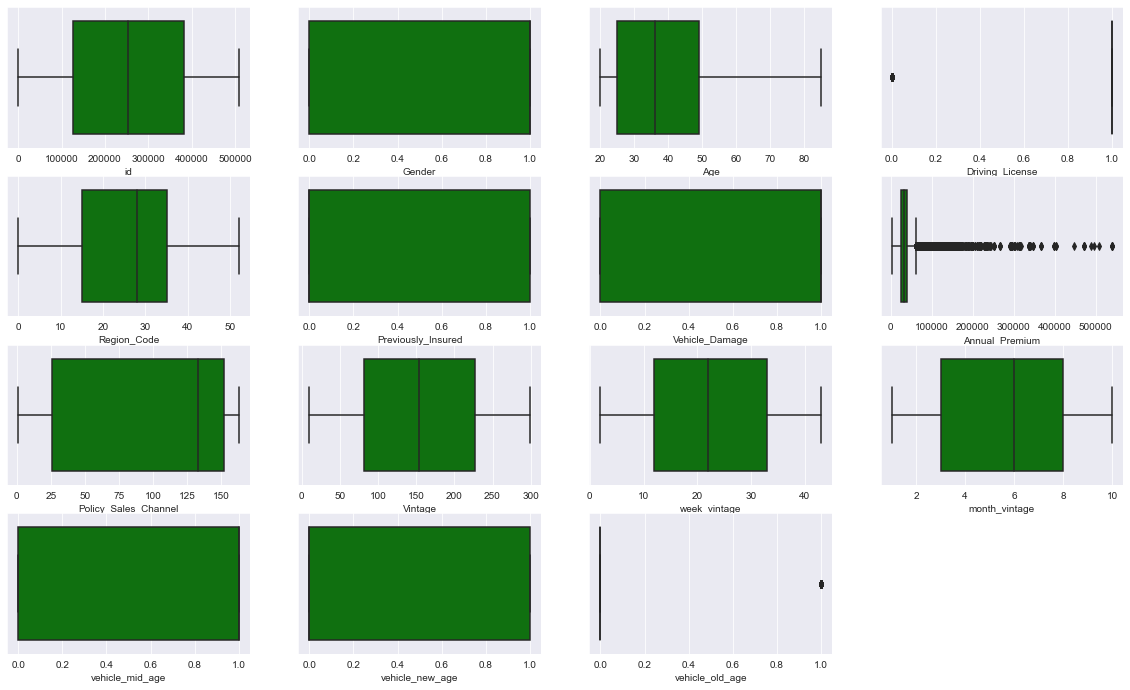

In [36]:
# Numerical columns
x_train_num = x_train.select_dtypes(exclude='object')

# Checking outliers
plt.figure(figsize=(20, 15))

for i in range(len(x_train_num.columns)):
    plt.subplot(5, 4, i + 1)
    sns.boxplot(x_train_num[x_train_num.columns[i]], color='green')

plt.show()

### 5.3.2. Robust Scaler

In [37]:
# Robust Scaler for variables with high outlier influence
rs = RobustScaler()
x_train.Age = rs.fit_transform(x_train[['Annual_Premium']].values)
x_test.Age = rs.transform(x_test[['Annual_Premium']].values)

### 5.3.3. MinMax Scaler

In [38]:
# MinMaxScaler for variables with low outliers influence
columns = ['Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'week_vintage', 'month_vintage',
       'vehicle_mid_age', 'vehicle_new_age', 'vehicle_old_age']
mms = MinMaxScaler()
x_train[columns] = mms.fit_transform(x_train[columns])
x_test[columns] = mms.transform(x_test[columns])

## 5.4. Standardization

None of the numerical variables have a normal distribution (see subsection 4.1.2)

# 6.0. Feature Selection

In [39]:
# Preparing dataset
X_train_boruta = x_train
Y_train_boruta = y_train

In [40]:
print(X_train_boruta.shape)
print(Y_train_boruta.shape)

(406516, 15)
(406516,)


## 6.1. Boruta as Feature Selector

In [41]:
# Train random forest classifier

# x_train
x_train_n = X_train_boruta.values

# y_train
y_train_n = Y_train_boruta.values.ravel()

# Define Random Forest Classifier
rf = RandomForestClassifier(n_jobs=4)

# Define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42, max_iter=100).fit(x_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	1
Rejected: 	14
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	0
Rejected: 	14


BorutaPy finished running.

Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	0
Rejected: 	14


In [42]:
# Check selected features
cols_selected_boruta = feat_selector.support_.tolist()
columns_selected = x_train.loc[:, cols_selected_boruta].columns.tolist()
columns_selected

['id']

In [43]:
# Tentar splitar nas etápas posteriores ao enconding para ver se o boruta seleciona as features certas